## Long Run Mean Growth Rates for Discount and Return Processes

#### Qingyin Ma, John Stachurski and Alexis Akira Toda

In [1]:
import numpy as np
from scipy.linalg import eig, eigvals
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import cm
import quantecon as qe

In [2]:
def tauchen(mu, rho, sigma_u, N=5, n_std=3):
    """
    Using Tauchen's method to discretization to compute the Markov 
    matrix associated with the linear Gaussian AR(1) process

        y_{t+1} = mu + rho * y_t + u_{t+1}, 
        {u_t} ~iid N(0, sigma_u^2).

    Parameters
    ----------
    mu  : scalar(float)
        The constant term of {y_t}
    rho : scalar(float)
        The autocorrelation coefficient
    sigma_u : scalar(float)
        The standard deviation of {u_t}
    N : scalar(int), optional(default=7)
        The number of states to use in the approximation
    n_std : scalar(int), optional(default=3)
        The number of standard deviations to approximate out to
    
    Returns
    -------
    states : array_like(float, ndim=1)
        The state space of the discretized process
    P : array_like(float, ndim=2)
        The Markov transition matrix where P[i, j] is the probability
        of transitioning from x[i] to x[j]

    """
    # CDF of the normal distribution
    F = norm(loc=0, scale=sigma_u).cdf 

    # the stationary standard deviation of {y_t}
    std_y = np.sqrt(sigma_u**2 / (1-rho**2))

    # distance from the center
    x_bar = n_std * std_y

    # discretized state space (mean normalized)
    x = np.linspace(-x_bar, x_bar, N)

    step = x[1] - x[0]
    half_step = 0.5 * step
    P = np.empty((N, N))

    for i in range(N):
        P[i, 0] = F(x[0] - rho * x[i] + half_step)
        P[i, N-1] = 1 - F(x[N-1] - rho * x[i] - half_step)
        for j in range(1, N-1):
            z = x[j] - rho * x[i]
            P[i, j] = F(z + half_step) - F(z - half_step)
    
    # renormalize the matrix to avoid rounding errors
    row_sums = P.sum(axis=1)
    P = P / row_sums[:, np.newaxis]
    
    # center process around its mean: mu / (1 - rho)
    states = mu / (1 - rho) + x 

    return states, P

## Random Discounting


In [3]:
class RandomDiscounting:
    """
    The AR(1) random discounting model.
    """
    def __init__(self, 
                 μ=0.99,    # stationary mean of {β_t}
                 ρ=0.992,   # autocorrelation coefficient of {β_t}
                 σ=0.006,   # standard deviation of {β_t}
                 N=15):     # number of states of the discretized {β_t} process      
        self.μ, self.ρ, self.σ, self.N = μ, ρ, σ, N 
        
        # discretize {β_t} process
        #self.Z_β, self.P = tauchen((1 - ρ) * μ, ρ, np.sqrt(1 - ρ**2) * σ, N=N)
        mc = qe.rouwenhorst(N, (1 - ρ) * μ, np.sqrt(1 - ρ**2) * σ, ρ)  
        self.Z_β, self.P = mc.state_values, mc.P

    def Gβ(self):
        """
        Evaluate the long-run average growth rate of {β_t}
        """
        Z_β, P = self.Z_β, self.P 
        
        D_β = np.diag(Z_β) 
        L_β = P @ D_β         
        G_β = max(np.abs(eigvals(L_β)))  # G_β = r(L_β)
        return G_β

In [4]:
rd = RandomDiscounting()

In [5]:
rd.Gβ()

0.9943155894974464

In [6]:
rd.Z_β

array([0.96755006, 0.97075719, 0.97396433, 0.97717146, 0.9803786 ,
       0.98358573, 0.98679287, 0.99      , 0.99320713, 0.99641427,
       0.9996214 , 1.00282854, 1.00603567, 1.00924281, 1.01244994])

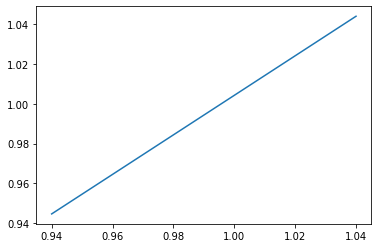

In [7]:
M = 50
mu_seq = np.linspace(0.94, 1.04, M)
out = np.empty(M)
for i in range(M):
    rd = RandomDiscounting(μ=mu_seq[i])
    out[i] = rd.Gβ()

fig, ax = plt.subplots()
ax.plot(mu_seq, out)
plt.show()

A function for generating contour plots.

In [8]:
def contour_Gβ(ρ_min=0.96,       # grid point of minimum ρ value
               ρ_max=0.99,    # grid point of maximum ρ value
               ρ_size=50,       # size of grid points for ρ 
               σ_min=0.01,    # grid point of minimum σ value
               σ_max=0.015,       # grid point of maximum σ value
               σ_size=50):      # number of grid points for σ
    """
    Evaluate G_β for a class of ρ and σ values.
    """
    ρ_grid = np.linspace(ρ_min, ρ_max, ρ_size)  # grid points for ρ
    σ_grid = np.linspace(σ_min, σ_max, σ_size)  # grid points for σ
    
    Gβ_matrix = np.empty((ρ_size, σ_size))  # create empty matrix to store G_β values
    
    for (i_ρ, ρ) in enumerate(ρ_grid):
        for (i_σ, σ) in enumerate(σ_grid):
            rd = RandomDiscounting(ρ=ρ, σ=σ)
            Gβ_matrix[i_ρ, i_σ] = rd.Gβ()
    
    return Gβ_matrix, ρ_grid, σ_grid

In [9]:
Gβ_matrix, ρ_grid, σ_grid = contour_Gβ(ρ_size=12, σ_size=12)

#### Make contour plot of G_β


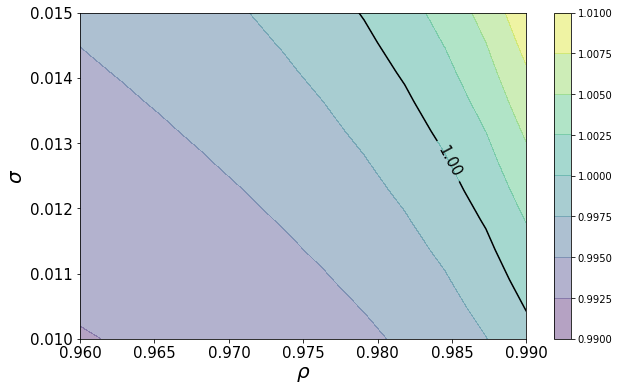

In [10]:
fig, ax = plt.subplots(figsize=(10,6))

Xβ, Yβ = np.meshgrid(ρ_grid, σ_grid)

# hide high values in Gβ_matrix 
Zβ = Gβ_matrix
Zβ[Zβ > 1.5] = np.nan

CSβ_f=ax.contourf(Xβ, Yβ, Zβ.T, alpha=0.4)
plt.colorbar(CSβ_f, ax=ax)

levels=[1.0]

CSβ = ax.contour(Xβ, Yβ, Gβ_matrix.T, colors='k', 
                 levels=levels)

ax.clabel(CSβ, inline=1, fontsize=15, fmt="%1.2f")

ax.set_xlabel("$\\rho$", fontsize=20)
ax.set_ylabel("$\sigma$", fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.savefig('gb.pdf')
plt.show()

# Verifying the Stability Conditions

### The model is as follows:

> $\log R_t = \mu_t + \sigma_t \zeta_t$,
 $\, \{\zeta_t\} \overset{iid}{\sim} N(0,1)$
 <br>
 $\mu_t = \bar{\mu} (1 - \rho_\mu) + \rho_\mu \mu_{t-1} 
    + \upsilon_t^\mu$, 
  $\, (\upsilon_t^\mu) \overset{iid}{\sim} N(0, \delta_\mu^2)$
 <br>
 $\log \sigma_t = \bar{\sigma} (1 - \rho_\sigma) 
    + \rho_\sigma \log \sigma_{t-1} 
    + \upsilon_t^\sigma$,
  $\, \{\upsilon_t^\sigma\} \overset{iid}{\sim} N(0, \delta_\sigma^2)$

We use Tauchen's method to discretize $\{\mu_t\}$ and $\{\sigma_t\}$ into finite-state Markov chains,
<br>
with state spaces $\mathsf{Z_\mu}$ and $\mathsf{Z_\sigma}$, respectively.

### Define the following:

- $\mathsf{Z}_\mu := \{i_1, \cdots, i_M \}, 
   \quad 
   \mathsf{Z}_\sigma := \{ j_1, \cdots, j_N \}$
   
- $D_\mu := \text{diag} 
            \left(
                \text{e}^{i_1}, \cdots, \text{e}^{i_M} 
            \right), 
   \quad
   D_\sigma := \text{diag} 
               \left(
                   \text{e}^{\, j_1^2 / 2}, 
                   \cdots, 
                   \text{e}^{\, j_N^2 / 2} 
               \right)$
   
- $V_\mu := \left( 
                \text{e}^{(1 - \gamma) i_1}, 
                \cdots, 
                \text{e}^{(1 - \gamma) i_M} 
            \right)',
   \quad
   V_\sigma := \left( 
                   \text{e}^{(1 - \gamma)^2 j_1^2 / 2}, 
                   \cdots, 
                   \text{e}^{(1 - \gamma)^2 j_N^2 / 2} 
               \right)'$

### Sufficient conditions for stability:

\begin{equation}
    \beta \, r(P_\mu D_\mu) \cdot r(P_\sigma D_\sigma) < 1  
\end{equation}

\begin{equation}
    \kappa := \beta \, \| P_\mu V_\mu \| \cdot \| P_\sigma V_\sigma \| < 1
\end{equation}

\begin{equation}
    r(P_\mu D_\mu) \cdot r(P_\sigma D_\sigma) \cdot \kappa^{1 / \gamma} < 1
\end{equation}

where
- $\| \mathbf{x} \|$ denotes the largest modulus of all the elements in vector $\mathbf{x}$.
- $r(A)$ is the spectral radius of matrix $A$, i.e., the largest modulus of all the eigenvalues of A.

## Model I. Constant $\{ \mu_t\}$ process

The model reduces to:

> $\log R_t = \mu + \sigma_t \zeta_t$, 
 $\, \{\zeta_t\} \overset{iid}{\sim} N(0,1)$
 <br>
 $\log \sigma_t = \bar{\sigma} (1 - \rho_\sigma) 
    + \rho_\sigma \log \sigma_{t-1} 
    + \upsilon_t^\sigma$,
  $\, \{\upsilon_t^\sigma\} \overset{iid}{\sim} N(0, \delta_\sigma^2)$
  
- $\mu = \bar \mu$ is the stationary mean of the AR(1) process $\{\mu_t\}$.

In [11]:
class IFP_StochasticVolatility:
    """
    Model I. Stochastic wealth returns with stochastic volatility.
    """
    def __init__(self, β=0.95,    # the discount factor
                 γ=1.5,           # the relative risk aversion coefficient
                 μ=0.0281,        # mean parameter related to {R_t}
                 σ_bar=-3.2556,   # stationary mean of the AR(1) process {σ_t}
                 ρ_σ=0.2895,      # autoregressive coefficient of the AR(1) process {σ_t}
                 δ_σ=0.1896,      # standard deviation of the {υσ_t} process
                 K=5,             # number of states of the discretized {σ_t} process
                 verbose=False):
        self.β, self.γ, self.K, self.verbose = β, γ, K, verbose
        self.μ, self.σ_bar, self.ρ_σ, self.δ_σ = μ, σ_bar, ρ_σ, δ_σ
        
        # discretize {σ_t} process
        # self.Z_σ, self.P_σ = tauchen(self.σ_bar*(1-self.ρ_σ), self.ρ_σ, self.δ_σ, N=self.K)
        mc = qe.rouwenhorst(K, σ_bar*(1-ρ_σ), δ_σ, ρ_σ)
        self.Z_σ, self.P_σ = mc.state_values, mc.P

        self.Z_σ = np.exp(self.Z_σ)

    def stability_test(self):
        """
        Stability test of the model economy. 
        """
        β, γ, verbose = self.β, self.γ, self.verbose
        μ, Z_σ, P_σ = self.μ, self.Z_σ, self.P_σ
        
        # ===== long-run average growth rate of {R_t} ===== #
        D_R = np.diag(np.exp(μ + Z_σ**2 / 2))
        if D_R.max() == np.inf:  
            G_R = np.nan  
        else:
            L_R = np.matmul(P_σ, D_R)        # L_R = P D_R
            G_R = max(np.abs(eig(L_R)[0]))   # G_R = r(L_R) 
        
        # ============= stability test ============= # 
        D_μ = np.exp(μ)
        D_σ = np.diag(np.exp(Z_σ**2 / 2.))
        
        V_μ = np.exp((1. - γ) * μ)
        V_σ = np.exp(((1. - γ)**2) * (Z_σ**2) / 2.)
        
        if D_σ.max()==np.inf or V_σ.max()==np.inf:
            lhs_cond1, lhs_cond2, lhs_cond3 = np.nan, np.nan, np.nan
        else:
            # r(P_μ D_μ) r(P_σ D_σ)
            spec_rad = D_μ * max(eig(np.matmul(P_σ, D_σ))[0])
            # β r(P_μ D_μ) r(P_σ D_σ) 
            lhs_cond1 = β * spec_rad
            # κ := β \|P_μ V_μ \| \|P_σ V_σ\|
            lhs_cond2 = β * V_μ * max(np.matmul(P_σ, V_σ))
            # r(P_μ D_μ) r(P_σ D_σ) κ^{1/γ}
            lhs_cond3 = spec_rad * (lhs_cond2**(1/γ))
        
        # sufficient conditions for stability 
        cond1 = (lhs_cond1 < 1.)
        cond2 = (lhs_cond2 < 1.)
        cond3 = (lhs_cond3 < 1.)
        stability = (cond1 and cond2 and cond3)
        
        if verbose:
            if cond1 and cond2 and cond3:
                print("")
                print("Stability conditions are verified!")
                print("")
                print("Ready for the next step!")
                print("")
            else:
                print("")
                print("Error!!!")
                print("")
                print("Stability conditions are violated!")
                print("")
                print("Adjust parameter values!")
                print("")
            print("------------------------------------")
            print("G_R = ", G_R)
            print("")
            print("Condition 1: ", lhs_cond1)
            print("")
            print("Condition 2: ", lhs_cond2)
            print("")
            print("Condition 3: ", lhs_cond3)
            print("------------------------------------")
            print("")
                
        return G_R, stability

In [12]:
# stability range
def stability_range_sv(ρ_σ_min=0.0,     # grid point of minimum ρ_σ value
                        ρ_σ_max=0.99,   # grid point of maximum ρ_σ value
                        ρ_σ_size=50,    # size of grid points for ρ_σ
                        δ_σ_min=1e-3,   # grid point of minimum δ_σ value
                        δ_σ_max=1.4,    # grid point of minimum δ_σ value
                        δ_σ_size=50):   # size of grid points for δ_σ
    
    ρ_σ_grid = np.linspace(ρ_σ_min, ρ_σ_max, ρ_σ_size)  # grid points for ρ_σ
    δ_σ_grid = np.linspace(δ_σ_min, δ_σ_max, δ_σ_size)  # grid points for δ_σ
    
    info_matrix = np.empty((ρ_σ_size, δ_σ_size))  # create empty matrix to store stability test results
    GR_matrix = np.empty((ρ_σ_size, δ_σ_size))    # create empty matrix to store G_R values
    
    for (i_ρ, ρ) in enumerate(ρ_σ_grid):
        for (i_σ, σ) in enumerate(δ_σ_grid):
            ifp_svr = IFP_StochasticVolatility(ρ_σ=ρ, δ_σ=σ)
            GR_matrix[i_ρ,i_σ], info_matrix[i_ρ,i_σ] = ifp_svr.stability_test()
    
    return GR_matrix, info_matrix, ρ_σ_grid, δ_σ_grid

GR_matrix, info_matrix, ρ_σ_grid, δ_σ_grid = stability_range_sv(ρ_σ_size=100, δ_σ_size=100)

C:\Users\Public\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in cdouble_scalars
C:\Users\Public\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp
C:\Users\Public\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp
C:\Users\Public\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in exp


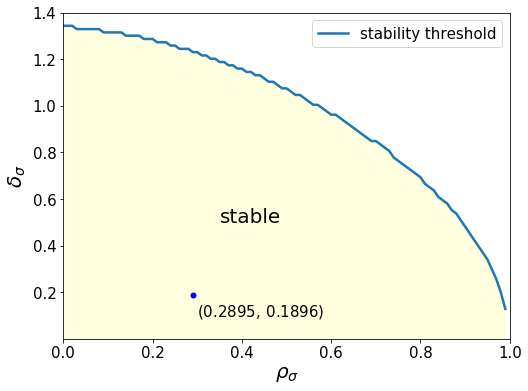

In [13]:
# find the threshold of stability range 
idx = np.minimum(np.sum(info_matrix, axis=1), len(δ_σ_grid)-1) 
idx = idx.astype(int)     # threshold index of the δ_σ grid points
δ_thresh = δ_σ_grid[idx]  # threshold δ_σ values 

# Plot the stability range
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(ρ_σ_grid, δ_thresh, label='stability threshold', lw=2.5)

ax.set_xlabel(r'$\rho_\sigma$', size=20)
ax.set_ylabel(r'$\delta_\sigma$', size=20)
ax.set_xlim((0.0, 1.0))
ax.set_ylim((0.0, 1.4))
#ax.set_title('Model 1: γ=%i' %γ, size=20)
plt.xticks(fontsize=15)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4], fontsize=15)

font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        }

ax.text(0.35, 0.5, 'stable', fontdict=font)
#ax.text(0.55, 1.0, 'unstable', fontdict=font)

ax.plot([0.2895], [0.1896], marker='o', markersize=5, color="blue")
ax.text(0.3, 0.1, "$(0.2895, \, 0.1896)$", family="sans-serif", size=15)

ax.fill_between(ρ_σ_grid, δ_thresh, color='lightyellow')

ax.legend(fontsize=15)

plt.savefig('sv_stb.pdf')

plt.show()

C:\Users\Public\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


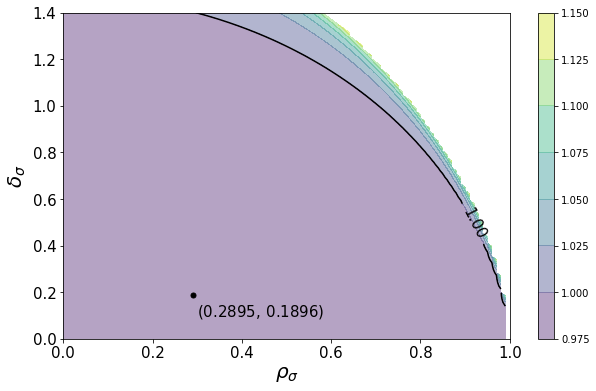

In [14]:
# ------------------------------------- #
#     make contour plot of G_R
# ------------------------------------- #
fig, ax = plt.subplots(figsize=(10,6))

X1, Y1 = np.meshgrid(ρ_σ_grid, δ_σ_grid)

# hide high values in GR_matrix 
Z1 = GR_matrix
Z1[Z1 > 1.2] = np.nan

β = IFP_StochasticVolatility().β

CS1_f = ax.contourf(X1, Y1, β*Z1.T, alpha=0.4)
plt.colorbar(CS1_f, ax=ax)

levels=[1.00]

CS1 = ax.contour(X1, Y1, β*Z1.T, colors='k', levels=levels)
ax.clabel(CS1, inline=1, fontsize=15, fmt="%1.2f")

ax.plot([0.2895], [0.1896], marker='o', markersize=5, color="black")
ax.text(0.3, 0.1, "$(0.2895, \, 0.1896)$", family="sans-serif", size=15)

ax.set_xlabel("$\\rho_\sigma$", fontsize=20)
ax.set_ylabel("$\delta_\sigma$", fontsize=20)

plt.xticks([0.0,0.2,0.4,0.6,0.8,1.0], fontsize=15)
plt.yticks([0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4], fontsize=15)

plt.savefig('sv_gr.pdf')

plt.show()

## Model II: Constant $\{ \sigma_t \}$ Process

The model reduces to:

> $\log R_t = \mu_t + \sigma \zeta_t$, 
$(\zeta_t) \overset{iid}{\sim} N(0,1)$ <br>
> $\mu_t = \bar{\mu} (1 - \rho_\mu) + \rho_\mu \mu_{t-1} 
    + \upsilon_t^\mu$, 
  $\, (\upsilon_t^\mu) \overset{iid}{\sim} N(0, \delta_\mu^2)$
  
- $\sigma = e^{\bar \sigma + \delta_\sigma^2 / 2(1 - \rho_\sigma^2)}$: 
the stationary mean of the AR(1) process $\{\sigma_t\}$

In [15]:
class IFP_MeanPersistence:
    """
    Model II. Stochastic wealth returns with mean persistence.
    """
    def __init__(self, β=0.95,  # the discount factor
                 γ=1.5,         # the relative risk aversion coefficient
                 σ=0.0393,      # standard deviation parameter related to {R_t}
                 μ_bar=0.0281,  # stationary mean of the AR(1) process {μ_t}
                 ρ_μ=0.5722,    # autoregressive coefficient of the AR(1) process {μ_t}
                 δ_μ=0.0067,    # standard deviation of the {υμ_t} process
                 M=5,           # number of states of the discretized {μ_t} process
                 verbose=False):
        self.β, self.γ, self.M, self.verbose = β, γ, M, verbose
        self.σ, self.μ_bar, self.ρ_μ, self.δ_μ = σ, μ_bar, ρ_μ, δ_μ
        
        # discretize {μ_t} process
        #self.Z_μ, self.P_μ = tauchen(self.μ_bar*(1-self.ρ_μ), self.ρ_μ, self.δ_μ, N=self.M)
        mc = qe.rouwenhorst(M, μ_bar*(1-ρ_μ), δ_μ, ρ_μ)
        self.Z_μ, self.P_μ = mc.state_values, mc.P

    def stability_test(self):
        """
        Stability test of the model economy.
        """
        β, γ, M, verbose = self.β, self.γ, self.M, self.verbose
        σ, Z_μ, P_μ = self.σ, self.Z_μ, self.P_μ
        
        # ===== long-run average growth rate of {R_t} ===== #
        D_R = np.diag(np.exp(Z_μ + σ**2 / 2))
        
        if D_R.max() == np.inf:
            G_R = np.nan
        else:
            L_R = np.matmul(P_μ, D_R)        # L_R = P D_R
            G_R = max(np.abs(eig(L_R)[0]))   # G_R = r(L_R)
            
        # ============= stability test ============= # 
        D_σ = np.exp(σ**2 / 2.)
        D_μ = np.diag(np.exp(Z_μ))
        
        V_σ = np.exp(((1. - γ)**2) * (σ**2) / 2.)
        V_μ = np.exp((1. - γ) * Z_μ)
        
        if D_μ.max()==np.inf or V_μ.max()==np.inf:
            lhs_cond1, lhs_cond2, lhs_cond3 = np.nan, np.nan, np.nan
        else:
            # r(P_R D_R) = r(P_μ D_μ) r(P_σ D_σ)
            spec_rad = D_σ * max(eig(np.matmul(P_μ, D_μ))[0])
            # β r(P_μ D_μ) r(P_σ D_σ) 
            lhs_cond1 = β * spec_rad
            # κ := β \|P_μ V_μ \| \|P_σ V_σ\|
            lhs_cond2 = β * V_σ * max(np.matmul(P_μ, V_μ))
            # r(P_μ D_μ) r(P_σ D_σ) κ^{1/γ}
            lhs_cond3 = spec_rad * (lhs_cond2**(1/γ))
        
        # sufficient conditions for stability 
        cond1 = (lhs_cond1 < 1.)
        cond2 = (lhs_cond2 < 1.)
        cond3 = (lhs_cond3 < 1.)
        stability = (cond1 and cond2 and cond3)
        
        if verbose:
            if cond1 and cond2 and cond3:
                print("")
                print("Stability conditions are verified!")
                print("")
                print("Ready for the next step!")
                print("")
            else:
                print("")
                print("Error!!!")
                print("")
                print("Stability conditions are violated!")
                print("")
                print("Adjust parameter values!")
                print("")
            print("------------------------------------")
            print("G_R = ", G_R)
            print("")
            print("Condition 1: ", lhs_cond1)
            print("")
            print("Condition 2: ", lhs_cond2)
            print("")
            print("Condition 3: ", lhs_cond3)
            print("------------------------------------")
            print("")
                
        return G_R, stability

In [16]:
# stability range
def stability_range_mp(ρ_μ_min=0.0,    # grid point of minimum ρ_μ value
                       ρ_μ_max=0.99,   # grid point of maximum ρ_μ value
                       ρ_μ_size=50,    # size of grid points for ρ_μ 
                       δ_μ_min=1e-3,   # grid point of minimum δ_μ value
                       δ_μ_max=0.14,   # grid point of minimum δ_μ value
                       δ_μ_size=50):   # size of grid points for δ_μ 
    
    ρ_μ_grid = np.linspace(ρ_μ_min, ρ_μ_max, ρ_μ_size)  # grid points for ρ_μ
    δ_μ_grid = np.linspace(δ_μ_min, δ_μ_max, δ_μ_size)  # grid points for δ_μ
    
    info_matrix = np.empty((ρ_μ_size, δ_μ_size))  # create empty matrix to store stability test results
    GR_matrix = np.empty((ρ_μ_size, δ_μ_size))    # create empty matrix to store G_R values
    
    for (i_ρ, ρ) in enumerate(ρ_μ_grid):
        for (i_δ, δ) in enumerate(δ_μ_grid):
            ifp_mp = IFP_MeanPersistence(ρ_μ=ρ, δ_μ=δ)
            GR_matrix[i_ρ, i_δ], info_matrix[i_ρ, i_δ] = ifp_mp.stability_test()
    
    return GR_matrix, info_matrix, ρ_μ_grid, δ_μ_grid

GR_matrix_mp, info_matrix_mp, ρ_μ_grid, δ_μ_grid = stability_range_mp(ρ_μ_size=100, δ_μ_size=100)

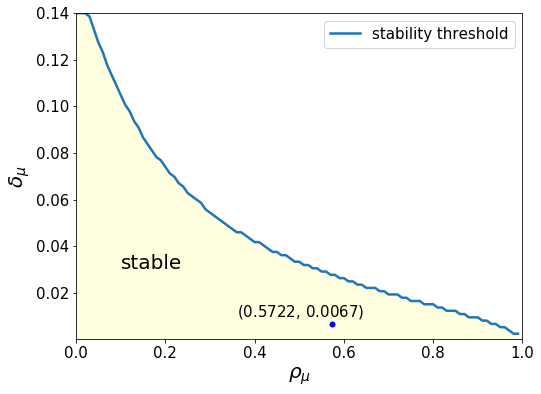

In [17]:
# find the threshold of stability range
idx = np.minimum(np.sum(info_matrix_mp, axis=1), len(δ_μ_grid)-1)
idx = idx.astype(int)       # threshold index on the δ_σ grid points
δ_μ_thresh = δ_μ_grid[idx]  # threshold δ_σ values 

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(ρ_μ_grid, δ_μ_thresh, label='stability threshold', lw=2.5)

ax.set_xlabel(r'$\rho_\mu$', size=20)
ax.set_ylabel(r'$\delta_\mu$', size=20)
ax.set_xlim((0.0, 1.0))
ax.set_ylim((0.0, 0.14))
#ax.set_title('Model 2: γ=%i' %γ, size=15)
plt.xticks(fontsize=15)
plt.yticks([0.02,0.04,0.06,0.08,0.10,0.12,0.14], fontsize=15)


font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        }

ax.text(0.1, 0.03, 'stable', fontdict=font)
#ax.text(0.3, 0.05, 'unstable', fontdict=font)

ax.plot([0.5722], [0.0067], marker='o', markersize=5, color="blue")
ax.text(0.36, 0.01, "$(0.5722, \, 0.0067)$", family="sans-serif", size=15)

ax.fill_between(ρ_μ_grid, δ_μ_thresh, color='lightyellow')

ax.legend(fontsize=15)

plt.savefig('mp_stb.pdf')

plt.show()

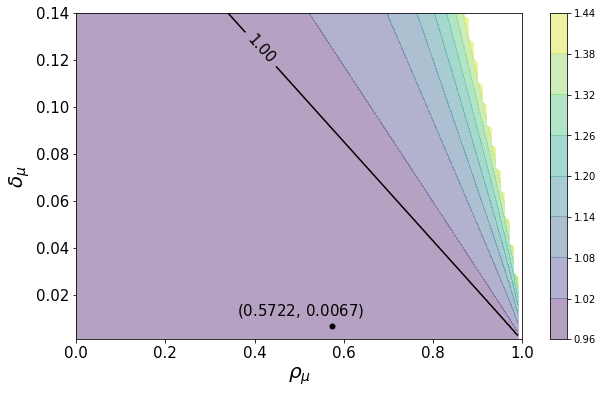

In [18]:
# ------------------------------------- #
#     make contour plot of G_R
# ------------------------------------- #
fig, ax = plt.subplots(figsize=(10,6))

X2, Y2 = np.meshgrid(ρ_μ_grid, δ_μ_grid)

# hide high values in GR_matrix 
Z2 = GR_matrix_mp
Z2[Z2 > 1.5] = np.nan

β = IFP_MeanPersistence().β

CS2_f = ax.contourf(X2, Y2, β*Z2.T, alpha=0.4)
plt.colorbar(CS2_f, ax=ax)

levels = [1.0]

CS2 = ax.contour(X2, Y2, β*Z2.T, colors='k', levels=levels)

ax.clabel(CS2, inline=1, fontsize=15, fmt="%1.2f")

ax.plot([0.5722], [0.0067], marker='o', markersize=5, color="black")
ax.text(0.36, 0.011, "$(0.5722, \, 0.0067)$", family="sans-serif", size=15)

ax.set_xlabel("$\\rho_\mu$", fontsize=20)
ax.set_ylabel("$\delta_\mu$", fontsize=20)

plt.xticks([0.0,0.2,0.4,0.6,0.8,1.0], fontsize=15)
plt.yticks(fontsize=15)

plt.savefig('mp_gr.pdf')

plt.show()